In [1]:
%reset -f

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import data_process, data_functions, data_generator, keras_model
from path import path_dict, col_seq_cc, col_seq_elx

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [4]:
%config Completer.use_jedi = False

In [5]:
pmpm = pd.read_pickle("../temp/pmpm_ccm.p")

In [6]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_IP  ALLOW_ER  \
0  2612620  201510        M               75          0       0.0       0.0   
1  2613447  201510        M               75       2159       0.0       0.0   
2  2613818  201510        M               75        176       0.0       0.0   
3  2740429  201510        M               61          0       0.0       0.0   
4  2736648  201510        M               61        213       0.0       0.0   

   CC_HYPOTHYROID  CC_AMI  CC_ALZHEIMER  ...  CC_HEPATITIS_A  \
0               0       0             0  ...               0   
1               0       0             0  ...               0   
2               0       0             0  ...               0   
3               0       0             0  ...               0   
4               0       0             0  ...               0   

   CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  \
0                     0                       0                     0   
1                     0                       0                     0   
2                     0                       0                     0   
3                     0                       0                     0   
4                     0                       0                     0   

   CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  \
0                       0                           0               0   
1                       0                           0               0   
2                       0                           0               0   
3                       0                           0               0   
4                       0                           0               0   

   CC_HEPATITIS_E  CC_DX_CNT  CC_DISAB_DX_CNT  
0               0          0                0  
1               0          7                0  
2               0          7                0  
3               0          1                0  
4               0          1                0  

[5 rows x 76 columns]

In [7]:
def get_training_date_range(pmpm, start, end):
    date_list = pmpm.MYR.sort_values().unique().tolist()
    start_index = date_list.index(start)
    end_index = date_list.index(end)
    return date_list[start_index:end_index+1]

In [8]:
def return_stacked_training_data(pmpm, train_start, train_end):
    
    training_period = get_training_date_range(pmpm.copy(), train_start, train_end)
    print(f"Training Period: {training_period}")
    print(f"Loading and Stacking Training Data...")
    
    for i, month in enumerate(training_period):
        
        if i+6 >= len(training_period):
            break
        
        start_month = month
        end_month = training_period[i+5]
        label_month = training_period[i+6]
        print(f"Loading Data from {start_month} to {end_month} and labels from {label_month}")
        
        if i==0:
            
            training_data = data_generator.generate_data(pmpm.copy(), start_month, end_month, features=True, col_seq=col_seq_cc)
            training_labels = data_generator.generate_data(pmpm.copy(), label_month, label_month, features=True, col_seq=col_seq_cc)
            training_data, training_labels = data_generator.make_intersection(training_data, training_labels)

            print(f"{training_data.shape} samples added with {training_labels.shape} labels")
            
        else:
            new_training_data = data_generator.generate_data(pmpm.copy(), start_month, end_month, features=True, col_seq=col_seq_cc)
            new_training_labels = data_generator.generate_data(pmpm.copy(), label_month, label_month, features=True, col_seq=col_seq_cc)
            new_training_data, new_training_labels = data_generator.make_intersection(new_training_data, new_training_labels)
            
            print(f"{new_training_data.shape} samples added with {new_training_labels.shape} labels")
            
            training_data = training_data.append(new_training_data, ignore_index=True)
            training_labels = training_labels.append(new_training_labels, ignore_index=True)
            
        print(f"Current Trainset size {training_data.shape}")
        
    return training_data, training_labels

In [9]:
%%time
train_data, training_labels = return_stacked_training_data(pmpm.copy(), 201601, 201612)

Training Period: [201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612]
Loading and Stacking Training Data...
Loading Data from 201601 to 201606 and labels from 201607
(410582, 74) samples added with (410582, 74) labels
Current Trainset size (410582, 74)
Loading Data from 201602 to 201607 and labels from 201608
(406725, 74) samples added with (406725, 74) labels
Current Trainset size (817307, 74)
Loading Data from 201603 to 201608 and labels from 201609
(405645, 74) samples added with (405645, 74) labels
Current Trainset size (1222952, 74)
Loading Data from 201604 to 201609 and labels from 201610
(403328, 74) samples added with (403328, 74) labels
Current Trainset size (1626280, 74)
Loading Data from 201605 to 201610 and labels from 201611
(400355, 74) samples added with (400355, 74) labels
Current Trainset size (2026635, 74)
Loading Data from 201606 to 201611 and labels from 201612
(392353, 74) samples added with (392353, 74) labels
Current Tr

In [10]:
train_data = train_data.dropna()

In [11]:
train_data

AGE_AT_MIDMONTH  MBR_GNDR    ALLOW_AMT    ALLOW_ER  ALLOW_IP  \
0                     39       0.0    78.166667    0.000000       0.0   
1                     36       1.0     0.000000    0.000000       0.0   
2                    103       0.0   344.333333    0.000000       0.0   
3                    102       1.0   621.500000   58.496667       0.0   
4                    102       0.0  1015.666667  223.476667       0.0   
...                  ...       ...          ...         ...       ...   
2418983               43       1.0   452.166667    0.000000       0.0   
2418984               27       0.0   214.000000    0.000000       0.0   
2418985               18       0.0   740.833333    0.000000       0.0   
2418986                3       0.0     7.666667    0.000000       0.0   
2418987                4       1.0    79.000000    0.000000       0.0   

         CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0              0             0                  0       0          0  ...   
1              0             0                  0       0          0  ...   
2              0             6                  6       0          0  ...   
3              0             0                  0       0          0  ...   
4              0             0                  0       0          0  ...   
...          ...           ...                ...     ...        ...  ...   
2418983        0             0                  0       0          0  ...   
2418984        0             0                  0       0          0  ...   
2418985        0             0                  0       0          0  ...   
2418986        0             0                  0       0          0  ...   
2418987        0             0                  0       0          0  ...   

         CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  \
0                         0        0                 0   
1                         0        0                 0   
2                         0        0                 0   
3                         0        0                 0   
4                         0        0                 0   
...                     ...      ...               ...   
2418983                   0        0                 0   
2418984                   0        0                 0   
2418985                   0        0                 0   
2418986                   0        0                 0   
2418987                   0        0                 0   

         CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  \
0                             0               0                0          0   
1                             0               0                0          0   
2                             0               0                0          0   
3                             0               0                0          0   
4                             0               0                0          0   
...                         ...             ...              ...        ...   
2418983                       0               0                0          0   
2418984                       0               0                0          0   
2418985                       0               0                0          0   
2418986                       0               0                0          0   
2418987                       0               0                0          0   

         CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                 0                   0                 0  
1                 0                   0                 0  
2                 0                   0                 0  
3                 0                   0                 0  
4                 0                   0                 0  
...             ...                 ...               ...  
2418983           0                   0                 0  
2418984           0                   0                 0  
2418985           0  

In [12]:
training_labels = training_labels.dropna()

In [13]:
training_labels

AGE_AT_MIDMONTH  MBR_GNDR  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  \
0                     39       0.0        444      0.00       0.0        0   
1                     36       1.0          0      0.00       0.0        0   
2                    104       0.0       1708      0.00       0.0        0   
3                    102       1.0        125      0.00       0.0        0   
4                    102       0.0       4348   1565.02       0.0        0   
...                  ...       ...        ...       ...       ...      ...   
2418983               43       1.0          0      0.00       0.0        0   
2418984               27       0.0        108      0.00       0.0        0   
2418985               18       0.0        749      0.00       0.0        0   
2418986                3       0.0        127      0.00       0.0        0   
2418987                4       1.0          0      0.00       0.0        0   

         CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0                   0                  0       0          0  ...   
1                   0                  0       0          0  ...   
2                   1                  1       0          0  ...   
3                   0                  0       0          0  ...   
4                   0                  0       0          0  ...   
...               ...                ...     ...        ...  ...   
2418983             0                  0       0          0  ...   
2418984             0                  0       0          0  ...   
2418985             0                  0       0          0  ...   
2418986             0                  0       0          0  ...   
2418987             0                  0       0          0  ...   

         CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  \
0                         0        0                 0   
1                         0        0                 0   
2                         0        0                 0   
3                         0        0                 0   
4                         0        0                 0   
...                     ...      ...               ...   
2418983                   0        0                 0   
2418984                   0        0                 0   
2418985                   0        0                 0   
2418986                   0        0                 0   
2418987                   0        0                 0   

         CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  \
0                             0               0                0          0   
1                             0               0                0          0   
2                             0               0                0          0   
3                             0               0                0          0   
4                             0               0                0          0   
...                         ...             ...              ...        ...   
2418983                       0               0                0          0   
2418984                       0               0                0          0   
2418985                       0               0                0          0   
2418986                       0               0                0          0   
2418987                       0               0                0          0   

         CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                 0                   0                 0  
1                 0                   0                 0  
2                 0                   0                 0  
3                 0                   0                 0  
4                 0                   0                 0  
...             ...                 ...               ...  
2418983           0                   0                 0  
2418984           0                   0                 0  
2418985           0                   0                 0  
2418986  

In [14]:
baseline_model = keras_model.make_model_6(input_shape=train_data.shape[1])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 74)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4800      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [15]:
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_data.values, training_labels.values, epochs=num_epochs, validation_split=0.1, batch_size=128, verbose=1)

Train on 2177089 samples, validate on 241899 samples
Epoch 1/20
2177089/2177089 [==============================] - 48s 22us/step - loss: 427042.6484 - mean_absolute_error: 9.6323 - val_loss: 184609.2482 - val_mean_absolute_error: 6.3878
Epoch 2/20
2177089/2177089 [==============================] - 48s 22us/step - loss: 426775.3214 - mean_absolute_error: 9.4207 - val_loss: 184932.8468 - val_mean_absolute_error: 6.4003
Epoch 3/20
2177089/2177089 [==============================] - 48s 22us/step - loss: 428298.7231 - mean_absolute_error: 10.4661 - val_loss: 183150.5261 - val_mean_absolute_error: 6.5674
Epoch 4/20
2177089/2177089 [==============================] - 48s 22us/step - loss: 428053.8252 - mean_absolute_error: 11.5226 - val_loss: 177594.7141 - val_mean_absolute_error: 6.5424
Epoch 5/20
2177089/2177089 [==============================] - 48s 22us/step - loss: 427893.5534 - mean_absolute_error: 11.3933 - val_loss: 175726.1476 - val_mean_absolute_error: 6.8625
Epoch 6/20
2177089/21770

In [16]:
baseline_history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

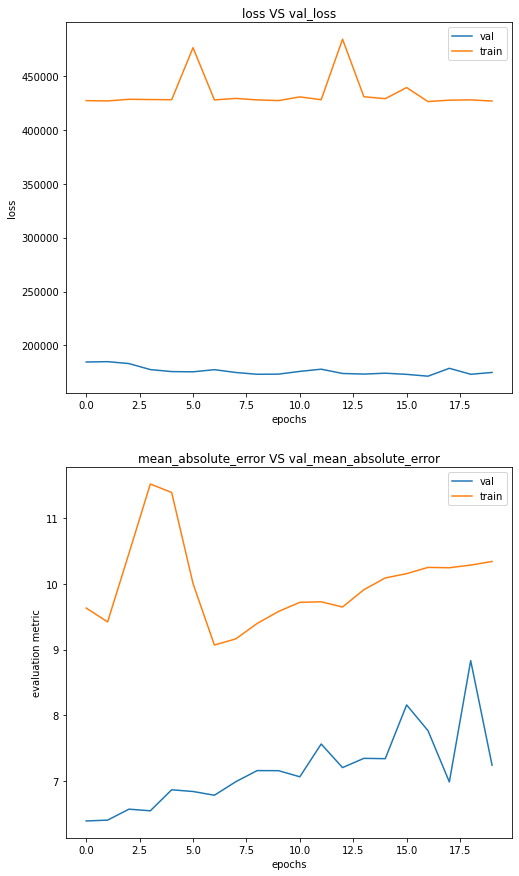

In [17]:
keras_model.plot_history(baseline_history, num_epochs, figsize=(8, 15))